# Calculate subset SHAP values for the 10k cohort patients, attending each hospital
## Create a plot to show the patient subset SHAP + hospital subset SHAP gives IVT decision

## Plain English summary

We will create a "subset SHAP value" for each feature. The 10 features in the model can be classified as either those that are describing the patients characteristics (the “patient descriptive features”) or those that are describing the hospital’s processes (the “hospital descriptive features”). There are eight patient descriptive features (age, stroke severity, prior disability, onset-to-arrival time, stroke type, type of onset time, anticoagulants, and onset during sleep) and there are two hospital descriptive features (arrival-to-scan time, and hospital attended). For this analysis, we only included the single one-hot encoded feature for the attended hospital (and did not include the other 131 one-hot encoded features for the unattended hospitals). We calculated the subset SHAP value for each feature by only including the components of it's SHAP value that exclusively contain the effect from the features in the same subset. This is expressed as the sum of the main effect and the interaction effects with the other features within it’s subset. For the feature “arrival to scan”, which is part of the hospital descriptive subset, its subset SHAP value is the main effect plus the interaction with the feature hospital attended. For each of the features in the patient descriptive subset, its subset SHAP value is the main effect plus the sum of the interactions with each of the other seven patient descriptive features. For each set of descriptive features (hospital and patient) we fitted a multiple regression to predict the hospitals observed thrombolysis rate from the median refined SHAP value of each feature for patients attending each hospital (using values from the all data model).

These values can be compared with the modular/embedded neural network that has a network per subset of features (hospital and patient).

## Model and data

(Use the model as trained in notebook 04)

An XGBoost model is trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.The 10k patient cohort is then used in two ways: 1) as the test set for the model fitting process 2) as a common set of patients that are sent to each hospital in turn to obtain a thrombolysis rate that is comparable across hosptials which has any patient factors removed.

The XGBoost model is fitted to all but 10k instances, and uses 10 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Train XGBoost model on all data except for a 10k set of patients
* Predict use of thrombolysis in the heldback 10k cohort of patients at their attended hosptial
* Calculate the "subset SHAP values" for each feature

For each patient provide:
* Clinical subset SHAP (total)
* Hospital subset SHAP (total)
* Hospital main SHAP alone
* Total SHAP
* Number of 132 hospitals that would be expected to give the patient thrombolysis (calculated from data saved in notebook 04)

## Observations
* Each unit has a different 'patient threshold' where they are willing to use thrombolysis - a sigmoid distribution.
* The hospital SHAP (that is added to the patient SHAP) decides whether to thrombolyse a patient - pretty normally distributed.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap
import copy

from scipy import stats

import pickle

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier

from os.path import exists
import json

import math

## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_key_features = 10
model_text = f'xgb_{number_key_features}_features_10k_cohort'
notebook = '04c'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [5]:
data_loc = '../data/10k_training_test/'

In [6]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=dict_feature_name, inplace=True)
test = test[key_features]
test.rename(columns=dict_feature_name, inplace=True)

Store list of unique stroke teams

In [7]:
hospitals = list(set(train['Stroke team']))
hospitals.sort()
n_hospitals = len(hospitals)

Store list of attended hospital (one per patient)

In [8]:
test_stroke_team = test['Stroke team']

## Fit XGBoost model

Fit or read in XGBoost model on the 10k cohort train/test dataset, and calculate model accuracy.

Save models.

In [9]:
# Fit models (True), or load models (False)
#fit_models = False#True

# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
#X_train_stroke_team = X_train['Stroke team']
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
#X_test_stroke_team = X_test['Stroke team']
X_test.drop('Stroke team', axis=1, inplace=True)    

filename = (f'./saved_models/04_{model_text}.p')
file_exists = exists(filename)

if file_exists:
    # Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    # Define model
    model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
    # Fit model
    model.fit(X_train, y_train)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)

# Get predicted probabilities and class for 10k cohort
y_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
#y_pred = y_prob > 0.5

thrombolysis_rate = []
thrombolysis_rate.append(y_pred.mean())
    
# Save predictions
single_predictions = []
single_predictions.append(y_pred * 1)

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848


Calculate receiver operating characteristic curve area under curve.

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print (f'ROC ACUC: {roc_auc:.3f}')

ROC ACUC: 0.915


## SHAP interactions

### Define the features in each subset

Have two subsets: patient and hosptial

In [11]:
patient_features = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

hospital_features = ['Arrival-to-scan time','Stroke team']

Get order of columns from text set (use this to extract columns in the shap interaction matrix

In [12]:
col_names = list(X_test.columns)
col_names[:10]

['Arrival-to-scan time',
 'Infarction',
 'Stroke severity',
 'Precise onset time',
 'Prior disability level',
 'Use of AF anticoagulants',
 'Onset-to-arrival time',
 'Onset during sleep',
 'Age',
 'team_AGNOF1041H']

### Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature)

A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.

Use these values to access the main effect for each of the one-hot encoded hospital features.

Either load from pickle (if file exists), or calculate.

#### At the same tiume: Format the SHAP interaction data so only get the main effect for the hospital features

Features are in the same order in shap_interaction as they are in the original dataset.

Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns:
1. contribution from all the hospital features
2. contribution from attending the hospital
3. contribution from not attending the rest

SHAP interaction values have a matrix of values (per pair of features) per instance.

For each hospital, have the 10k instances each with a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

Once get the SHAP interaction values, calculate the subset SHAP values. This is the main effect + interactions with the features int he same subset (hospital, or patient)

In [13]:
# Get list of hospital one hot encoded column titles
hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
n_hospitals = len(hospitals_ohe)

# Create list of column index for these hospital column titles
hospital_columns_index = [X_test.columns.get_loc(col) for col in hospitals_ohe]

## Use the index list to access the hospital shap values (as array) in the loop below
#hosp_shap_main_effects = []

## get indices for the hospitals
#hospitals_indices = [col_names.index(h) for h in hospitals_ohe]
#len(hospitals_indices)

# Create SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(model)#, X_train)

In [14]:
%%time


filename = f'./output/{notebook}_{model_text}_shap_subset_values.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP subset data
    with open(filename, 'rb') as filehandler:
        df_shap_subset_values = pickle.load(filehandler)

else:
    # Create df_shap_subset_values
    
    # Initialise dataframe
    columns = (["patient_id", "hospital_attended", "patient_subset_total", 
                "hospital_subset_total"])
    df_subset_shap_totals = pd.DataFrame(columns = columns)

    # Get list of hospital one hot encoded column titles
    hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
    n_hospitals = len(hospitals_ohe)

    # Create list of column index for these hospital column titles
    hospital_columns_index = [X_test.columns.get_loc(col) for col in hospitals_ohe]

    ## Use the index list to access the hospital shap values (as array) in the loop below
    #hosp_shap_main_effects = []

    ## get indices for the hospitals
    #hospitals_indices = [col_names.index(h) for h in hospitals_ohe]
    #len(hospitals_indices)
    
    # number of instances in the test set (number of patients)
    n_test_patients = X_test.shape[0]
    patient_id = [i for i in range(n_test_patients)]
    
    # Create SHAP explainer for the XGBoost model
    explainer = shap.TreeExplainer(model)#, X_train)

    # For each hospital calculate SHAP values for the test set (all going to each hospital)
    count = 0
    for hospital in hospitals:
        count += 1
        print (f"Calculating SHAP subset values for hospital {count} of {len(hospitals)}")

        # get hospital the patient attends
        # Using the same hostpial for all 10K patients as determined by the loop. use "hospital " not "attend"
        #attend = test_stroke_team[p]
        # get column index for hospital attend
        hospital_keep_index = [col_names.index(f'team_{hospital}')]

        # get indices for the other hosptials (those not attend) to remove for 
        #   this patient
        hospitals_remove_indices = list(set(hospital_columns_index) - 
                                        set(hospital_keep_index))

        # remove the not attended hospitals from the column names
        col_names_attendhosp = np.delete(col_names, hospitals_remove_indices, 0)

        # rename the one hosptial left with the generic "Stroke team" name
        col_names_attendhosp = np.char.replace(col_names_attendhosp, 
                                               f'team_{hospital}', "Stroke team")

        # number of features in the resulting list
        n_si_features = col_names_attendhosp.shape[0]

        # get the indices for the features in each subset
        patient_features_col_id = [np.where(col_names_attendhosp==f)[0][0] 
                                   for f in patient_features]
        hospital_features_col_id = [np.where(col_names_attendhosp==f)[0][0] 
                                    for f in hospital_features]

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get SHAP interaction values for patients attending this hospital
        shap_interaction = explainer.shap_interaction_values(X_test_adjusted)

        # create list (one per value type) with features as column title
        shap_main_effects = []
        shap_interactions_within_subset = []
        subset_shap_values = []

        # For each patient work with their shap interaction matrix and calculate 
        #   the patient subset value and hospital subset value
        for p in range(shap_interaction.shape[0]):

            # get shap interactions for a patient
            si = shap_interaction[p]

            # delete the rows and columns in the shap interaction matrix for the 
            #   hospitals not attended
            shap_interaction_attendhosp = np.delete(si, hospitals_remove_indices, 0)
            shap_interaction_attendhosp = np.delete(shap_interaction_attendhosp, 
                                                    hospitals_remove_indices, 1)


            # calculate the subset values (main effect + interactions with those features in same subset

            # 1. main effect value for each of the features
            main_effects = np.diagonal(shap_interaction_attendhosp)

            # add to list (entry per patient contianing value per feature)
            shap_main_effects.append(main_effects)

            # 2. SHAP interactions within feature subgroup (patient, hospital)
            list_of_list = [patient_features_col_id,
                            hospital_features_col_id]

            # initialise a zero array with size of number of features (excluding 
            #   unattended hostpial)
            within_subset_array = np.zeros((n_si_features))
            # Through a list of subgroup features at a time
            for features_col_ids in list_of_list: 
                # Through features in subgroup
                for f1 in features_col_ids:
                    # Take a deep copy of all of the features
                    remaining = copy.deepcopy(features_col_ids)
                    # Remove the current feature (get a list of the other features in 
                    #   the subgroup
                    remaining.remove(f1)
                    # Initialise a variable to sum the interactions that are with
                    #   features from the same subgroup
                    sum_elements = 0
                    # Through the other features in the subgroup
                    for f2 in remaining:
                        sum_elements += shap_interaction_attendhosp[f1, f2]
                    # Store summed interactions in the array
                    within_subset_array[f1] = sum_elements

            # add to list (entry per patient containing value per feature)
            shap_interactions_within_subset.append(within_subset_array)

            # 3. Subset shap: sum array (2) + (3)
            subset_shap = main_effects + within_subset_array

            # add to list (entry per patient containing value per feature)
            subset_shap_values.append(subset_shap)

        df_subset_shap_values = (
                                pd.DataFrame(subset_shap_values, 
                                             columns=col_names_attendhosp))

        # Create temporary dataframe that comtains the values to then append to the master dataframe
        df_temp = pd.DataFrame()

        # patient ID
        df_temp["patient_id"] = patient_id

        # Clinical subset SHAP (total)
        df_temp["patient_subset_total"] = (df_subset_shap_values[patient_features].sum(axis=1))

        # Hospital subset SHAP (total)
        df_temp["hospital_subset_total"] = (df_subset_shap_values[hospital_features].sum(axis=1))

        df_temp["hospital_attended"] = [hospital] * n_test_patients
        
        # add to the master dataframe
        df_subset_shap_totals = df_subset_shap_totals.append(df_temp, ignore_index = True)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(df_subset_shap_totals, filehandler) 

Calculating SHAP subset values for hospital 1 of 132
Calculating SHAP subset values for hospital 2 of 132
Calculating SHAP subset values for hospital 3 of 132
Calculating SHAP subset values for hospital 4 of 132
Calculating SHAP subset values for hospital 5 of 132
Calculating SHAP subset values for hospital 6 of 132
Calculating SHAP subset values for hospital 7 of 132
Calculating SHAP subset values for hospital 8 of 132
Calculating SHAP subset values for hospital 9 of 132
Calculating SHAP subset values for hospital 10 of 132
Calculating SHAP subset values for hospital 11 of 132
Calculating SHAP subset values for hospital 12 of 132
Calculating SHAP subset values for hospital 13 of 132
Calculating SHAP subset values for hospital 14 of 132
Calculating SHAP subset values for hospital 15 of 132
Calculating SHAP subset values for hospital 16 of 132
Calculating SHAP subset values for hospital 17 of 132
Calculating SHAP subset values for hospital 18 of 132
Calculating SHAP subset values for ho

In [15]:
df_subset_shap_totals.head()

,patient_id,hospital_attended,patient_subset_total,hospital_subset_total
0,0,AGNOF1041H,-9.059255,0.770867
1,1,AGNOF1041H,-5.241642,0.386963
2,2,AGNOF1041H,-1.879134,0.823612
3,3,AGNOF1041H,1.906406,0.639743
4,4,AGNOF1041H,-1.87547,0.691649


# Analysing the subset SHAP data

Variation in patient's patient subset shap value across 132 hosptials

In [16]:
patient_subset_mean = df_subset_shap_totals.groupby(["patient_id"])["patient_subset_total"].mean()
patient_subset_std = df_subset_shap_totals.groupby(["patient_id"])["patient_subset_total"].std()

In [17]:
patient_subset_mean.sort_values()

patient_id
4815   -11.776454
5109   -11.423359
8522   -11.391347
774    -11.087187
88     -11.016638
          ...    
4033     3.104799
7308     3.116710
3498     3.119752
4519     3.142683
3146     3.214824
Name: patient_subset_total, Length: 10000, dtype: float64

In [119]:
patient_subset_mean.rank()

patient_id
0        197.0
1       1525.0
2       3238.0
3       8490.0
4       3138.0
         ...  
9995    1708.0
9996    3065.0
9997    7341.0
9998    5172.0
9999    6623.0
Name: patient_subset_total, Length: 10000, dtype: float64

In [30]:
df_patient_subset = patient_subset_mean.to_frame(name="patient_subset_mean")
df_patient_subset["patient_subset_std"] = patient_subset_std
df_patient_subset

,patient_subset_mean,patient_subset_std
patient_id,,
0,-9.033499,0.062774
1,-5.208293,0.084449
2,-1.830808,0.075844
3,1.918903,0.035864
4,-1.902394,0.065431
...,...,...
9995,-3.677330,0.072951
9996,-1.954418,0.068550
9997,1.006023,0.052826


In [31]:
df_patient_subset = df_patient_subset.sort_values("patient_subset_mean")
df_patient_subset

,patient_subset_mean,patient_subset_std
patient_id,,
4815,-11.776454,0.092833
5109,-11.423359,0.097525
8522,-11.391347,0.094507
774,-11.087187,0.087798
88,-11.016638,0.100083
...,...,...
4033,3.104799,0.052565
7308,3.116710,0.048076
3498,3.119752,0.065833


In [110]:
every_100_patient = [i for i in range(0, n_test_patients,100)]
every_100_patient.append(9999)
every_250_patient = [i for i in range(0, n_test_patients,250)]
every_250_patient.append(9999)
every_500_patient = [i for i in range(0, n_test_patients,500)]
every_500_patient.append(9999)
every_750_patient = [i for i in range(0, n_test_patients,750)]
every_750_patient.append(9999)
every_1000_patient = [i for i in range(0, n_test_patients,1000)]
every_1000_patient.append(9999)

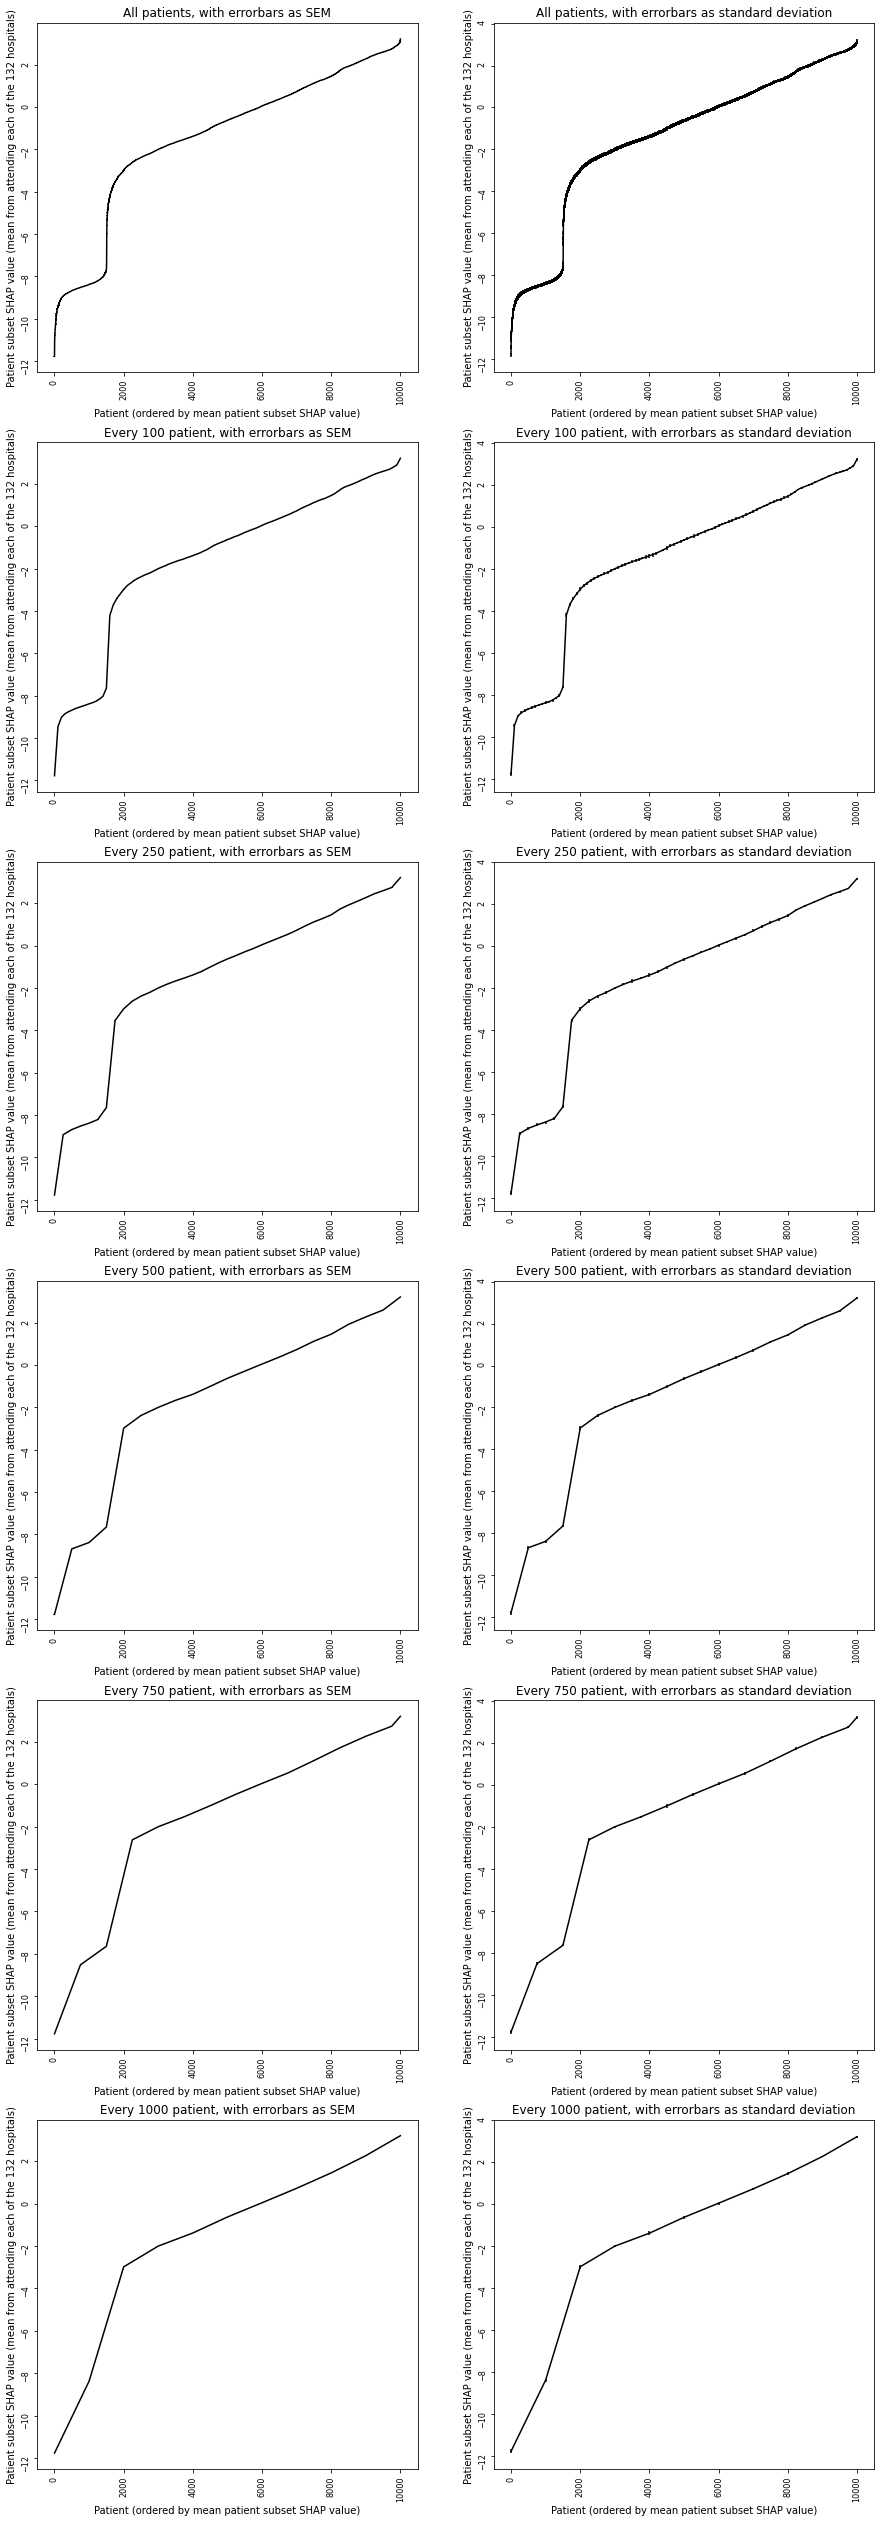

In [111]:
fig = plt.figure(figsize=(15,45))

# AXIS 1
ax = fig.add_subplot(621)
plt.errorbar(range(n_test_patients),
             df_patient_subset['patient_subset_mean'], 
             yerr=df_patient_subset['patient_subset_std']/math.sqrt(n_hospitals),
             color='k')
ax.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax.set_title('All patients, with errorbars as SEM')

# AXIS 2
ax = fig.add_subplot(622)
plt.errorbar(range(n_test_patients),
             df_patient_subset['patient_subset_mean'], 
             yerr=df_patient_subset['patient_subset_std'],
             color='k')
ax.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax.set_title('All patients, with errorbars as standard deviation')

# AXIS 3
ax1 = fig.add_subplot(623)
plt.errorbar(every_100_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_100_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_100_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 100 patient, with errorbars as SEM')

# AXIS 4
ax1 = fig.add_subplot(624)
plt.errorbar(every_100_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_100_patient], 
#             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df_patient_subset['patient_subset_std'].iloc[every_100_patient],
             color='k')

ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 100 patient, with errorbars as standard deviation')

# AXIS 5
ax1 = fig.add_subplot(625)
plt.errorbar(every_250_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_250_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_250_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 250 patient, with errorbars as SEM')

# AXIS 6
ax1 = fig.add_subplot(626)
plt.errorbar(every_250_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_250_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_250_patient],
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 250 patient, with errorbars as standard deviation')

# AXIS 7
ax1 = fig.add_subplot(627)
plt.errorbar(every_500_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_500_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_500_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 500 patient, with errorbars as SEM')

# AXIS 8
ax1 = fig.add_subplot(628)
plt.errorbar(every_500_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_500_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_500_patient],
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 500 patient, with errorbars as standard deviation')

# AXIS 9
ax1 = fig.add_subplot(629)
plt.errorbar(every_750_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_750_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_750_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 750 patient, with errorbars as SEM')

# AXIS 10
ax1 = fig.add_subplot(6,2,10)
plt.errorbar(every_750_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_750_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_750_patient],
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 750 patient, with errorbars as standard deviation')

# AXIS 11
ax1 = fig.add_subplot(6,2,11)
plt.errorbar(every_1000_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_1000_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_1000_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 1000 patient, with errorbars as SEM')

# AXIS 12
ax1 = fig.add_subplot(6,2,12)
plt.errorbar(every_1000_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_1000_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_1000_patient],
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')

ax1.set_title('Every 1000 patient, with errorbars as standard deviation')

#plt.savefig(
#        f'./output/{notebook}_{model_text}_patient_subset_shap_vs_number_'
#        f'hospitals_give_ivt_line_sem_errorbars.jpg', 
#        dpi=300)

plt.show()

Variation in hosptial's hospital subset shap value across 10k patients

In [19]:
hospital_subset_mean = df_subset_shap_totals.groupby(["hospital_attended"])["hospital_subset_total"].mean()
hospital_subset_std = df_subset_shap_totals.groupby(["hospital_attended"])["hospital_subset_total"].std()

In [67]:
df_hospital_subset = hospital_subset_mean.to_frame(name="hospital_subset_mean")
df_hospital_subset["hospital_subset_std"] = hospital_subset_std
df_hospital_subset

,hospital_subset_mean,hospital_subset_std
hospital_attended,,
AGNOF1041H,-0.225901,1.697446
AKCGO9726K,0.107238,1.441672
AOBTM3098N,-0.824519,1.644350
APXEE8191H,-0.350592,1.651811
ATDID5461S,-0.215993,1.693999
...,...,...
YPKYH1768F,-0.542129,1.613707
YQMZV4284N,0.062772,1.696528
ZBVSO0975W,-0.945536,1.649954


In [68]:
df_hospital_subset = df_hospital_subset.sort_values("hospital_subset_mean")
df_hospital_subset

,hospital_subset_mean,hospital_subset_std
hospital_attended,,
XPABC1435F,-2.269579,1.966170
ISXKM9668U,-1.486680,1.624008
LGNPK4211W,-1.479039,1.424029
OUXUZ1084Q,-1.477127,1.546472
HZMLX7970T,-1.476830,1.482235
...,...,...
QWKRA8499D,0.530232,1.613677
VKKDD9172T,0.594680,1.844534
GKONI0110I,0.654483,1.592664


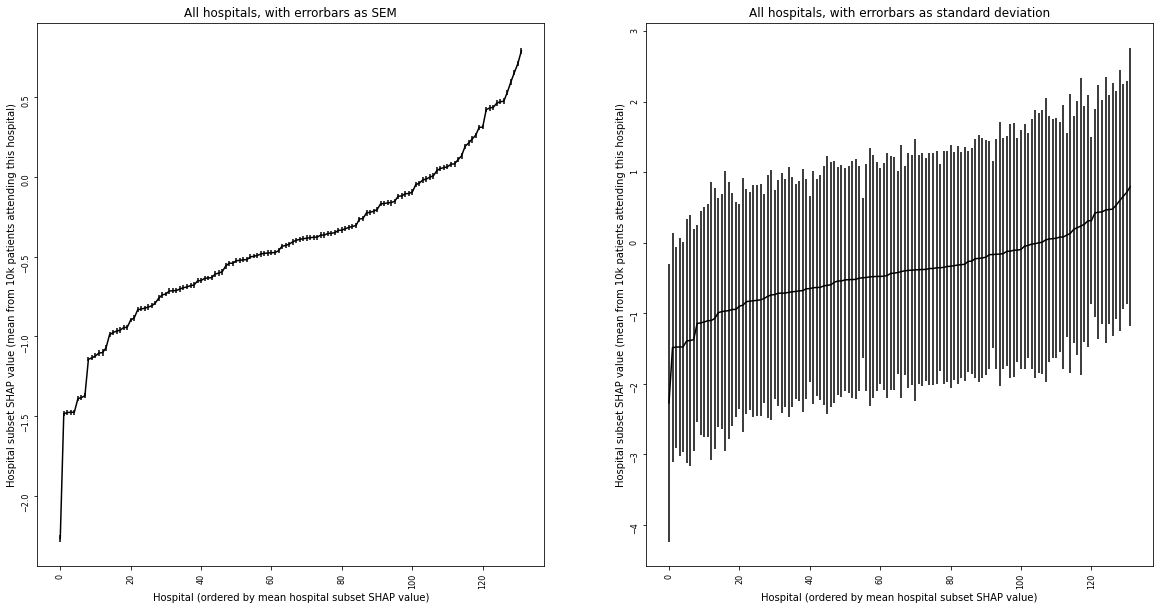

In [95]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
plt.errorbar(range(n_hospitals),
             df_hospital_subset['hospital_subset_mean'], 
#             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df_hospital_subset['hospital_subset_std']/math.sqrt(n_test_patients),
             color='k')
ax.set_xlabel('Hospital (ordered by mean hospital subset SHAP value)')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Hospital subset SHAP value (mean from 10k patients attending this hospital)')
ax.set_title('All hospitals, with errorbars as SEM')

ax = fig.add_subplot(122)
plt.errorbar(range(n_hospitals),
             df_hospital_subset['hospital_subset_mean'], 
             yerr=df_hospital_subset['hospital_subset_std'],
             color='k')
ax.set_xlabel('Hospital (ordered by mean hospital subset SHAP value)')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Hospital subset SHAP value (mean from 10k patients attending this hospital)')
ax.set_title('All hospitals, with errorbars as standard deviation')

plt.show()

Read in data about number of hosptials that give each patient IVT

In [156]:
filename = (f'./output/04_{model_text}_individual_predictions.csv')
patient_ivt_rate_10k = pd.read_csv(filename)

Create a plot to show the patient subset SHAP + hospital subset SHAP gives IVT decision.
Need to know the order of the hostpials for this data

In [157]:
patient_ivt_rate_10k

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
9998,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [158]:
df_patient_ivt_rate_10k = pd.DataFrame(data=patient_ivt_rate_10k)
df_patient_ivt_rate_10k.columns = hospitals
df_patient_ivt_rate_10k

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,XKAWN3771U,XPABC1435F,XQAGA4299B,XWUBX0795L,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
9998,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [159]:
df_patient_ivt_rate_10k["n_hospitals_IVT"] = df_patient_ivt_rate_10k.sum(axis=1)
df_patient_ivt_rate_10k

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,XPABC1435F,XQAGA4299B,XWUBX0795L,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,n_hospitals_IVT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,123
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9997,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,111
9998,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,12


In [136]:
df_patient_subset = df_patient_subset.sort_values("patient_id")
df_patient_subset

,patient_subset_mean,patient_subset_std
patient_id,,
0,-9.033499,0.062774
1,-5.208293,0.084449
2,-1.830808,0.075844
3,1.918903,0.035864
4,-1.902394,0.065431
...,...,...
9995,-3.677330,0.072951
9996,-1.954418,0.068550
9997,1.006023,0.052826


In [160]:
df_patient_ivt_rate_10k["patient_rank"] = patient_subset_mean.rank().astype(int)
df_patient_ivt_rate_10k

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,XQAGA4299B,XWUBX0795L,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,n_hospitals_IVT,patient_rank
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,197
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1525
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3238
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,123,8490
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1708
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3065
9997,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,0,111,7341
9998,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,12,5172


In [161]:
df_patient_ivt_rate_10k = df_patient_ivt_rate_10k.sort_values("patient_rank")
df_patient_ivt_rate_10k

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,XQAGA4299B,XWUBX0795L,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,n_hospitals_IVT,patient_rank
4815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
8522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,132,9996
7308,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,130,9997
3498,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,131,9998
4519,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,131,9999


In [162]:
df_patient_ivt_rate_10k.iloc[every_100_patient]

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,XQAGA4299B,XWUBX0795L,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,n_hospitals_IVT,patient_rank
4815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4979,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101
7397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201
1620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,301
6662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,1,1,0,121,9601
8055,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,0,1,1,126,9701
6291,1,1,1,1,1,1,0,1,1,1,...,0,1,1,1,1,0,1,1,114,9801
2259,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,132,9901


In [163]:
df_hospital_subset.index

Index(['XPABC1435F', 'ISXKM9668U', 'LGNPK4211W', 'OUXUZ1084Q', 'HZMLX7970T',
       'LFPMM4706C', 'HYCCK3082L', 'LECHF1024T', 'LZAYM7611L', 'IATJE0497S',
       ...
       'TPXYE0168D', 'HBFCN1575G', 'NTPQZ0829K', 'IAZKG9244A', 'MHMYL4920B',
       'QWKRA8499D', 'VKKDD9172T', 'GKONI0110I', 'HPWIF9956L', 'CNBGF2713O'],
      dtype='object', name='hospital_attended', length=132)

In [164]:
df_patient_ivt_rate_10k_to_plot1 = df_patient_ivt_rate_10k[df_hospital_subset.index].iloc[every_100_patient]
df_patient_ivt_rate_10k_to_plot1 = df_patient_ivt_rate_10k_to_plot1.T
df_patient_ivt_rate_10k_to_plot1

,4815,4979,7397,1620,6662,6590,4111,4333,6431,1123,...,7190,5187,3422,855,5067,5676,8055,6291,2259,3146
XPABC1435F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
ISXKM9668U,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,1,0,1,1
LGNPK4211W,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
OUXUZ1084Q,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
HZMLX7970T,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QWKRA8499D,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
VKKDD9172T,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GKONI0110I,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
HPWIF9956L,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


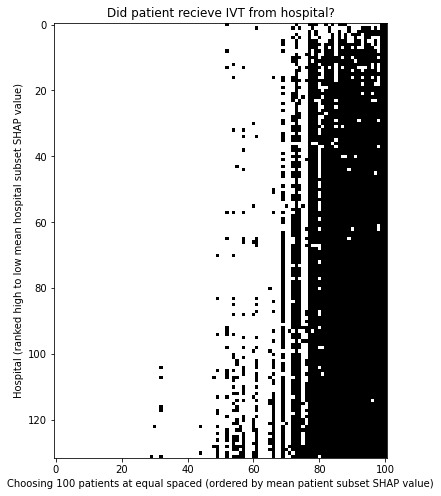

In [210]:
fig = plt.figure(figsize=(50,8))
ax = fig.add_subplot(111)
plt.imshow(df_patient_ivt_rate_10k_to_plot1, cmap='Greys')#,  interpolation='nearest')
ax.set_xlabel('Choosing 100 patients at equal spaced (ordered by mean patient subset SHAP value)')
ax.set_ylabel('Hospital (ranked high to low mean hospital subset SHAP value)')
ax.set_title('Did patient recieve IVT from hospital?')
plt.show()

Choose n patients from those that are getting IVT (in ranked subset shap value order)

In [202]:
int(df_patient_ivt_rate_10k_to_plot2.shape[0]/want_n_patients)

27

In [203]:
df_patient_ivt_rate_10k_to_plot2 = df_patient_ivt_rate_10k[df_patient_ivt_rate_10k["n_hospitals_IVT"]>0]
want_n_patients = 200
how_many_every_n_patients = int(df_patient_ivt_rate_10k_to_plot2.shape[0]/want_n_patients)
every_n_patient = [i for i in range(0, df_patient_ivt_rate_10k_to_plot2.shape[0], how_many_every_n_patients)]
every_n_patient.append(df_patient_ivt_rate_10k_to_plot2.shape[0]-1)

In [204]:
df_patient_ivt_rate_10k_to_plot2 = df_patient_ivt_rate_10k_to_plot2[df_hospital_subset.index].iloc[every_n_patient]
df_patient_ivt_rate_10k_to_plot2 = df_patient_ivt_rate_10k_to_plot2.T
df_patient_ivt_rate_10k_to_plot2

,8568,9800,6621,9996,6869,7776,4697,6303,5659,1002,...,1229,1362,9664,7530,7139,3100,3637,3215,6658,3146
XPABC1435F,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,1,1,1
ISXKM9668U,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,1,1
LGNPK4211W,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,1,1
OUXUZ1084Q,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,1,1
HZMLX7970T,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QWKRA8499D,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
VKKDD9172T,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GKONI0110I,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
HPWIF9956L,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


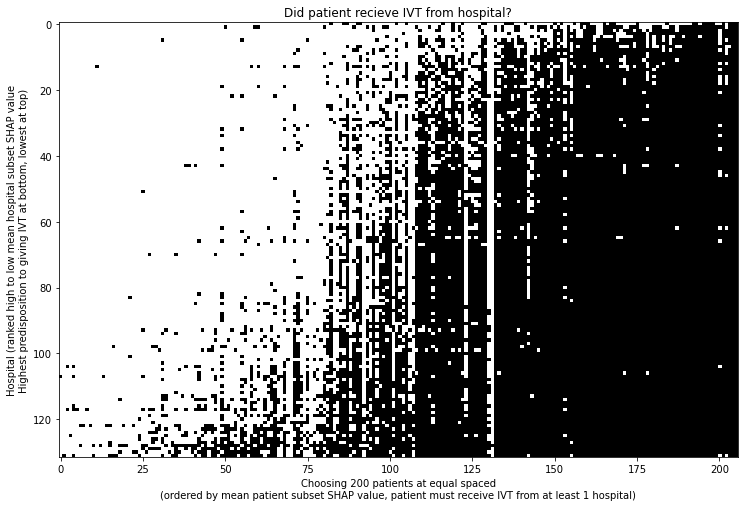

In [214]:
# seems the first number defines clarity, second defines size
fig = plt.figure(figsize=(50,8))
ax = fig.add_subplot(111)
plt.imshow(df_patient_ivt_rate_10k_to_plot2, cmap='Greys')#,  interpolation='nearest')
ax.set_xlabel('Choosing 200 patients at equal spaced\n(ordered by mean patient subset SHAP value, patient must receive IVT from at least 1 hospital)')
ax.set_ylabel('Hospital (ranked high to low mean hospital subset SHAP value\nHighest predisposition to giving IVT at bottom, lowest at top)')
ax.set_title('Did patient recieve IVT from hospital?')
plt.show()

Check out that patient around 130 with high patient subset value, but only 1 hospital give IVT

In [215]:
df_patient_ivt_rate_10k_to_plot2.sum(axis=0).min()

1

# Extra code

In [ ]:
fig = plt.figure(figsize=(15,25))

# AXIS 1
ax = fig.add_subplot(321)
plt.errorbar(range(n_test_patients),
             df_patient_subset['patient_subset_mean'], 
             yerr=df_patient_subset['patient_subset_std']/math.sqrt(n_hospitals),
             color='k')
ax.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax.set_title('All patients, with errorbars as SEM')

# AXIS 2
ax1 = fig.add_subplot(322)
plt.errorbar(every_100_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_100_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_100_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 100 patient, with errorbars as SEM')

# AXIS 3
ax1 = fig.add_subplot(323)
plt.errorbar(every_250_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_250_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_250_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 250 patient, with errorbars as SEM')

# AXIS 4
ax1 = fig.add_subplot(324)
plt.errorbar(every_500_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_500_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_500_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 500 patient, with errorbars as SEM')

# AXIS 5
ax1 = fig.add_subplot(325)
plt.errorbar(every_750_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_750_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_750_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 750 patient, with errorbars as SEM')

# AXIS 6
ax1 = fig.add_subplot(326)
plt.errorbar(every_1000_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_1000_patient], 
             yerr=df_patient_subset['patient_subset_std'].iloc[every_1000_patient]/math.sqrt(n_hospitals),
             color='k')
ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')
ax1.set_title('Every 1000 patient, with errorbars as SEM')

#plt.savefig(
#        f'./output/{notebook}_{model_text}_patient_subset_shap_vs_number_'
#        f'hospitals_give_ivt_line_sem_errorbars.jpg', 
#        dpi=300)

plt.show()

In [ ]:
fig = plt.figure(figsize=(15,25))
ax = fig.add_subplot(321)
plt.errorbar(range(n_test_patients),
             df_patient_subset['patient_subset_mean'], 
#             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df_patient_subset['patient_subset_std'],
             color='k')

ax.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax.tick_params(labelrotation=90, labelsize=8)
ax.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')

ax.set_title('All patients, with errorbars as standard deviation')

ax1 = fig.add_subplot(322)
plt.errorbar(every_100_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_100_patient], 
#             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df_patient_subset['patient_subset_std'].iloc[every_100_patient],
             color='k')

ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')

ax1.set_title('Every 100 patient, with errorbars as standard deviation')

ax1 = fig.add_subplot(323)
plt.errorbar(every_250_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_250_patient], 
#             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df_patient_subset['patient_subset_std'].iloc[every_250_patient],
             color='k')

ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')

ax1.set_title('Every 250 patient, with errorbars as standard deviation')

ax1 = fig.add_subplot(324)
plt.errorbar(every_500_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_500_patient], 
#             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df_patient_subset['patient_subset_std'].iloc[every_500_patient],
             color='k')

ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')

ax1.set_title('Every 500 patient, with errorbars as standard deviation')

ax1 = fig.add_subplot(325)
plt.errorbar(every_750_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_750_patient], 
#             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df_patient_subset['patient_subset_std'].iloc[every_750_patient],
             color='k')

ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')

ax1.set_title('Every 750 patient, with errorbars as standard deviation')

ax1 = fig.add_subplot(326)
plt.errorbar(every_1000_patient,
             df_patient_subset['patient_subset_mean'].iloc[every_1000_patient], 
#             df.iloc[19:]['avg_hosp_give_ivt'],
             yerr=df_patient_subset['patient_subset_std'].iloc[every_1000_patient],
             color='k')

ax1.set_xlabel('Patient (ordered by mean patient subset SHAP value)')
ax1.tick_params(labelrotation=90, labelsize=8)
ax1.set_ylabel('Patient subset SHAP value (mean from attending each of the 132 hospitals)')

ax1.set_title('Every 1000 patient, with errorbars as standard deviation')

#plt.savefig(
#        f'./output/{notebook}_{model_text}_patient_subset_shap_vs_number_'
#        f'hospitals_give_ivt_line_sem_errorbars.jpg', 
#        dpi=300)

plt.show()